# Newton-Cotes Integration

In [1]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

from parse_density_files import CUBE
import numpy as np
from matplotlib import pyplot as plt
import alchemy_tools2 as at
import scipy.integrate as intg

def get_alchpot_vals(cube, nucleus_pos):
    """
    calculate \rho/|r-R|
    """
    meshgrid = cube.get_grid()
    h_matrix = cube.get_hmatrix()
    distance_nuc_grid = at.distance_MIC2(nucleus_pos, meshgrid, h_matrix) # calculate distance of gpts to nucleus with MIC
    alch_pot_vals = -cube.data_scaled/distance_nuc_grid # integrate over position of electron density
    return(alch_pot_vals)

In [2]:
# get function at points in space
cube_x0 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/cube-files/ve_38.cube')
cube_x5 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_x5/DENSITY.cube')

In [13]:
# # calculate \rho/|r-R|
alch_pot_vals_x0 = get_alchpot_vals(cube_x0, cube_x0.atoms[8][1:4])
alch_pot_vals_x5 = get_alchpot_vals(cube_x5, cube_x5.atoms[8][1:4])

In [28]:
ax1 = 0
ax2 = 1
i_ax1 = np.where(cube_x0.get_axis(ax1, 'Bohr') < cube_x0.atoms[8][ax1 + 1])[0][-1]
i_ax2 = np.where(cube_x0.get_axis(ax2, 'Bohr') < cube_x0.atoms[8][ax2+1])[0][-1]
slice_dens = cube_x0.data_scaled[i_ax1, i_ax2]
slice_alchpot_x0 = alch_pot_vals_x0[i_ax1, i_ax2]
slice_alchpot_x5 = alch_pot_vals_x5[i_ax1, i_ax2]

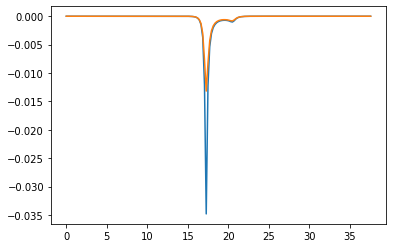

In [29]:
fig, ax =plt.subplots(1,1)
ax.plot(cube_x0.get_axis('z', 'Bohr'), slice_alchpot_x0)
ax.plot(cube_x5.get_axis('z', 'Bohr'), slice_alchpot_x5)

In [30]:
# integrals
def get_ints(sli):
    
    I0 = np.sum(sli)
    I1 = np.trapz(sli, cube_x0.get_axis('z', 'Bohr'))
    I2 = intg.simps(sli, cube_x0.get_axis('z', 'Bohr'))
    return(I0, I1, I2)

x0 = get_ints(slice_alchpot_x0)
x5 = get_ints(slice_alchpot_x5)

In [31]:
print(x0, x5)


(-0.08781213337776429, -0.018964698633429523, -0.017757940401901092) (-0.05312612673917484, -0.01147359646571345, -0.011320007940306694)


# Calculation of the second derivative between two points

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np

second derivative at x = 0.5 is according to finite difference scheme
\begin{equation}
    f''(x_i) = \frac{ f_{i+1} - 2 f_i + f_{i-1} }{h}
\end{equation}

$f_i$ is unkown. We estimate it by linear interpolation between $x_{i+1}, x_{i-1}$.
$ m = \frac{f_{i+1}-f_{i-1}}{x_{i+1} - x_{i-1}} $ but the second derivative of a first order polynomial is zero therefore this is not helpful

Instead we can use the average of the second derivatives of the enclosing points. The motivation is, that these values should become more similiar as the points come closer together.


In [ ]:
def linear_eq(x, y):
    m = (y[1]-y[0])/(x[1]-x[0])
    b = y[0] - m*x[0]
    return(m,b)

def d2_finite_diff(x,y):
    return((y[2] - 2*y[1] + y[0])/((x[2]-x[1])**2))

def predictor(x):
    x_vals = np.array([x-0.2, x, x+0.2])
    y_vals = np.exp(x_vals)
    return(x_vals, y_vals)

In [ ]:
x_1 = np.array([0.3, 0.4, 0.5])
y_1 = np.exp(x_1)
d2_finite_diff(x_1, y_1)

In [ ]:
x_2 = np.array([0.4, 0.5, 0.6])
y_2 = np.exp(x_2)
d2_finite_diff(x_2, y_2)

In [ ]:
(d2_finite_diff(x_1, y_1) + d2_finite_diff(x_2, y_2))/2

In [ ]:
np.exp(0.5)

In [ ]:
for i in [0.2, 0.4, 0.6]:
    x1,y1 = predictor(i)
    x2, y2 = predictor(i+0.2)
    print('Second derivative at x = {}'.format(i+0.1))
    f1 = d2_finite_diff(x1,y1)
    f2 = d2_finite_diff(x2,y2)
    mf = (f2+f1)/2
    print(mf)
    
    print(np.exp(i+0.1))
    print('Error = {}'.format(np.abs(mf-np.exp(i+0.1))))

In [ ]:
x_exact = np.linspace(0, 1, 100)
f_exact = np.exp(x_exact)

x_calc = np.linspace(0, 1, 6)
f_calc = np.exp(x_calc)

fig, ax = plt.subplots(1,1)
ax.plot(x_exact, f_exact)
ax.scatter(x_calc, f_calc)